<img src="https://blogs.mathworks.com/images/loren/2016/multiarmedbandit.jpg"></img>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib; matplotlib.rcParams['figure.figsize'] = (15,3)
from IPython.display import display

In [2]:
import numpy as np
import os

In [3]:
# Reload all packages - make debugging easier
%load_ext autoreload
%autoreload 2

---

In [4]:
from exp.utils import load_R, desparsify_2, prepare_test_users

In [5]:
R = load_R()

# One reason our model doesn't seem to work well may be due to the matrix being too sparse.
R = desparsify_2(R)

# The point of this is to check that if we can fine-tune a model and still obtain meaningful uncertainty **updates** per user.
# First, we pick a significant amount of users to check.
dense_users, spars_users, train_mask, test_masks = \
    prepare_test_users(R, NUM_USERS_DENSE = 5, NUM_USERS_SPARS = 0, PERC_DROP = 1.0)

R contains 100000 ratings
Before desparsify: % of items:  0.0630466936422
After desparsify: % of items:  0.373593572446
Size:  (354, 353)


In [6]:
# sanity check
print(np.sum(train_mask))
print(np.sum([np.sum(m) for _, m in test_masks.items()]))

45353
1332


---

Choose our model.

In [7]:
from pmf import PMF
model = PMF(ratingMatrix=R)

Some helper functions:

In [8]:
def plot_R(rhats, r=None, title=''):
    _, n_items = rhats.shape
    f, axes = plt.subplots(1, n_items, sharex=True, sharey=True)
    i = 0
    for j in range(n_items):
        if r is not None:
            axes[j].axvline(x=r[j], color='r', alpha=0.4)
        axes[j].hist(rhats[:,j], histtype='stepfilled', normed=True, bins=100)
    plt.xlim([0,6])
    f.suptitle(title)
    plt.show()
    
# Empirical Entropy of Ratings
from empirical_entropy import empirical_entropy
def get_entropy_data(model, user_index, intended_mask, num_samples=500):
    samples = model.sample_for_user(user_index, num_samples)
    _, per_item_entropy = empirical_entropy(samples)
    mean_all_entropy = np.mean(per_item_entropy[np.where(R[user_index,:] > 0)]) # all items we could see
    mean_intended_entropy = np.mean(per_item_entropy[np.where(intended_mask)]) # just elements we meant to test on
    return mean_all_entropy, mean_intended_entropy

# Latent Variable Entropy
def joint_entropy(vars):
    marginal_entropy = 0.5*np.log(2*np.pi*np.e*vars)
    joint_entropy = np.sum(vars, axis=1)
    return joint_entropy
    
# Fetch user latent variables and return their entropy for PMF
def get_user_latent_entropy_PMF(model, user):
    import tensorflow as tf

    sess = model.sess
    graph_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    U_var  = graph_vars[1]
    Up_var = graph_vars[3]

    U_entropy = joint_entropy(sess.run(tf.nn.softplus(U_var)))
    Up_entropy = joint_entropy(sess.run(tf.nn.softplus(Up_var)))
    
    return U_entropy[user], Up_entropy[user]

---

In [9]:
N_STEPS_INITIAL_TRAIN = 1500
N_STEPS_FINETUNE = 500

In [10]:
CHECKPOING_FILENAME = 'test_checkpoing_pmf1500.ckpt'

%time loss = model.train(train_mask, n_iter=N_STEPS_INITIAL_TRAIN)
model.save(CHECKPOING_FILENAME)

CPU times: user 43.4 s, sys: 7.96 s, total: 51.3 s
Wall time: 37.6 s


'test_checkpoing_pmf1500.ckpt'

In [11]:
from banditChoice import BanditChoice
bandit = BanditChoice()

def bandit_algo_random(samples, mask):
    _avail_idx = np.where(mask)[0]
    item = bandit.get_egreedy(samples[:,_avail_idx], _avail_idx, epsilon=1.0)
    return item

def bandit_algo_exploit(samples, mask):
    _avail_idx = np.where(mask)[0]
    item = bandit.get_egreedy(samples[:,_avail_idx], _avail_idx, epsilon=0.0)
    return item

def bandit_algo_egreedy(samples, mask):
    _avail_idx = np.where(mask)[0]
    item = bandit.get_egreedy(samples[:,_avail_idx], _avail_idx, epsilon=0.1)
    return item

def bandit_algo_ucb(samples, mask):
    _avail_idx = np.where(mask)[0]
    item = bandit.get_ucb(samples[:,_avail_idx], _avail_idx)
    return item

def test(users, bandit_algo, train=False, verbose=False):
    regret_per_user = {}
    for _, user in users:
        if verbose: print("---------------------- USER {} ----------------------".format(user))

        regret = []

        mask_ = np.copy(train_mask)
        test_mask_ = np.copy(test_masks[user])
        n_items = np.sum(test_mask_)

        cnt = 0

        for i in range(n_items):
            cnt += 1

            # Bandit
            samples = model.sample_for_user(user, 100)
            item = bandit_algo(samples, test_mask_)

            # Regret
            item_rating = R[user, item]
            best_item_rating = np.max(R[user, :] * test_mask_)
            regret.append(best_item_rating - item_rating)

            # Retrain
            mask_[user,item] = 1 # Showed this item; we can now train on it.
            test_mask_[item] = 0 # Can't show this item anymore.
            if train:
                model.load(CHECKPOING_FILENAME)
                model.train(mask_, n_iter=N_STEPS_FINETUNE)

        regret_per_user[user] = regret
    return regret_per_user

Evaluation helpers:

In [17]:
def plot_inst_regret(regret_per_user):
    for u_id, regret in regret_per_user.items():
        plt.plot(regret)
        plt.title("User {} regret over time".format(u_id))
    plt.show()
    
def plot_cum_regret(regret_per_user):
    for u_id, regret in regret_per_user.items():
        plt.plot(np.cumsum(regret))
        plt.title("User {} cumulative regret over time".format(u_id))
    plt.show()
        
def get_regret_stats(regret_per_user):
    if len(regret_per_user.items()) == 0:
        return float('nan'), float('nan')
    total_regret = sum([sum(regret) for _, regret in regret_per_user.items()])
    avg_regret = total_regret / len(regret_per_user.items())
    return total_regret, avg_regret

def print_regret_stats(regret_per_user):
    total_regret, avg_regret = get_regret_stats(regret_per_user)
    print("Total regret: {}".format(total_regret))
    print("Avg: {}".format(avg_regret))

In [23]:
%time dense20egreedy = test(dense_users[:20], bandit_algo_egreedy)
%time dense20random  = test(dense_users[:20], bandit_algo_random)
%time dense20exploit = test(dense_users[:20], bandit_algo_exploit)
%time spars20egreedy = test(spars_users[:20], bandit_algo_egreedy)
%time spars20random  = test(spars_users[:20], bandit_algo_random)
%time spars20exploit = test(spars_users[:20], bandit_algo_exploit)

CPU times: user 1min 56s, sys: 5.05 s, total: 2min 1s
Wall time: 37.2 s
CPU times: user 1min 56s, sys: 4.98 s, total: 2min 1s
Wall time: 36.2 s
CPU times: user 1min 56s, sys: 5.11 s, total: 2min 1s
Wall time: 37 s
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.87 µs
CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.15 µs


In [24]:
print_regret_stats(dense20egreedy)
print_regret_stats(dense20random)
print_regret_stats(dense20exploit)
print_regret_stats(spars20egreedy)
print_regret_stats(spars20random)
print_regret_stats(spars20exploit)

Total regret: 1575.0
Avg: 315.0
Total regret: 1629.0
Avg: 325.8
Total regret: 1632.0
Avg: 326.4
Total regret: nan
Avg: nan
Total regret: nan
Avg: nan
Total regret: nan
Avg: nan


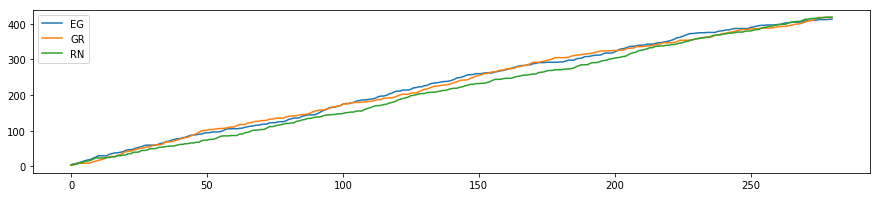

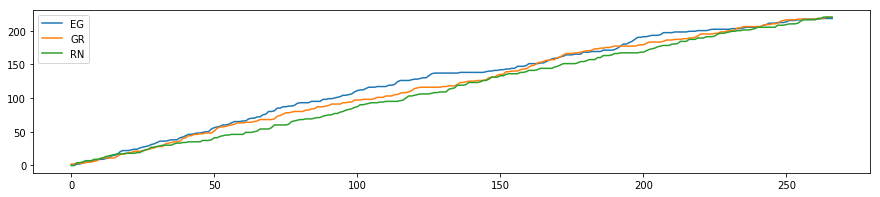

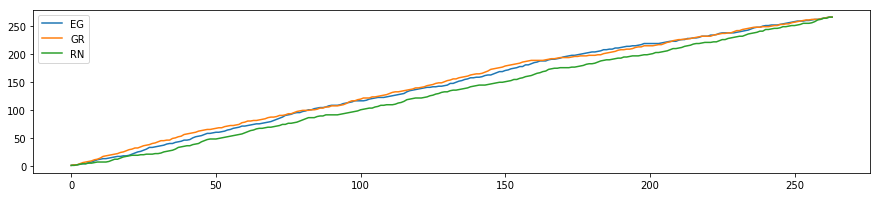

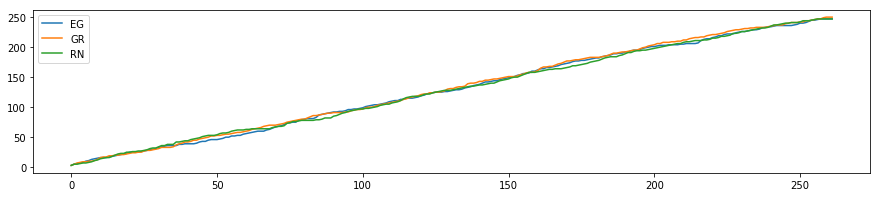

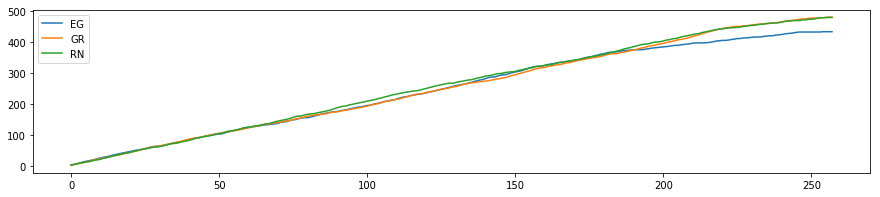

In [34]:
for user in dense20egreedy:
    plt.plot(np.cumsum(dense20egreedy[user]), label='EG')
    plt.plot(np.cumsum(dense20exploit[user]), label='GR')
    plt.plot(np.cumsum(dense20random[user]), label='RN')
    
    plt.legend()
    plt.show()

The results are slightly random. It would be better to take more samples.

Note for previous experiments, we used the spars_users. Here we use dense_users cuz it's all we got.

In [22]:
N_SAMPLES = 5

exploit = []
for _ in range(N_SAMPLES):
    regret_per_user = test(dense_users[:20], bandit_algo_exploit)
    total_regret, avg_regret = get_regret_stats(regret_per_user)
    exploit.append(avg_regret)
    
random = []
for _ in range(N_SAMPLES):
    regret_per_user = test(dense_users[:20], bandit_algo_random)
    total_regret, avg_regret = get_regret_stats(regret_per_user)
    random.append(avg_regret)
    
egreedy = []
for _ in range(N_SAMPLES):
    regret_per_user = test(dense_users[:20], bandit_algo_egreedy)
    total_regret, avg_regret = get_regret_stats(regret_per_user)
    egreedy.append(avg_regret)

KeyboardInterrupt: 

In [ ]:
plt.hist(exploit, histtype='step', label='exploit')
plt.hist(random, histtype='step', label='random')
plt.hist(egreedy, histtype='step', label='egreedy')
plt.legend()
plt.show()

---